In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits as pyfits
import scipy.stats as sc
import scipy.optimize as so
%matplotlib inline
import Jared_function as ai

In [3]:
def redshift(wavelength, restW):
    return (wavelength - restW)/restW #the redshift

def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2.0 * sigma**2))

def Mean(red, var):
    mean = np.sum(red / var) / np.sum(1 / var) #the mean of the data
    error = 1 / np.sum(1 / var) #the error of the mean
    return mean, error

def redshiftFinder(restwave,wave,flux):
    '''
    Finds an apoximent redshift through the use of cross coraltaion
    -----------------------------------------------------------------------------
    inputs
    restWave: an array of rest wavelengths
    wave: the wavelengths of the spectrum
    flux: the flux of the spectrum
    '''
    Sums = np.array([])
    redshift = np.arange(0,.02,.001)
    for z in redshift:
        compare = np.zeros(len(wave)) #an array of zeros
        con = 0
        Sum = 0
        for n in restwave:
            n = (z + 1) * n #the wavelegth ajusted for redshift
            m = np.abs(wave - n).argmin() #finds the index of the closet value to the shifted wave length
            if m > 0:
                compare[m] += 1. #adds one to an array of zeros 
        con = compare * flux.real #multiplies the flux array to the compare array
        Sum = np.sum(con)
        Sums = np.append(Sums, Sum) #apends the sum of the con array
    red = redshift[Sums == np.max(Sums)] #finds the redshift assosiated with the maximum of the Sums array
    return red[0]

def ultra_redshiftFinder_v2(wave, flux, center, offLeft, offRight, z, graph = True):
    '''
    finds the redshift through a gaussian fit of the data and plots the gaussian
        -----------------------------------------------------------------------------
    inputs
    wave: the wavelengths of the spectrum
    flux: the flux of the spectrum
    center: the wavelength that you are going to center around
    offleft: the offset to the left
    offright: the offset to the right
    z: the redshift that you are guessing
    graph: weather or not to make a graph
    '''
    center_a = center * (z + 1) #red shifts the meauserment point
    wave1 = wave[(wave > center_a - offLeft)*(wave < center_a + offRight)]
    flux1 = flux.real[(wave > center_a - offLeft)*(wave < center_a + offRight)]
    #selects an area around the center point
    ams, cov = so.curve_fit(gaussian, wave1, flux1, p0=[np.max(flux1),np.mean(wave1),np.sqrt(sc.moment(flux1,2))])
    #best fits a gaussian
    y = gaussian(wave1, ams[0],ams[1],ams[2])
    true_red = redshift(ams[1],center)
    error = np.sqrt(1 / (center)**2 * cov[1][1])
    #the error and redshift of the gaussian
    rms = np.sqrt(np.mean((flux1 - y)**2)) #the root mean square of the data
    if graph == True:
        plt.scatter(wave1,flux1)
        plt.plot(wave1,y)
    #plots the gaussian over the data
    return true_red, error, rms

def chiRedshift(red1,red2,error1,error2):
    return (red1 - red2)**2 / (error1**2 + error2**2)

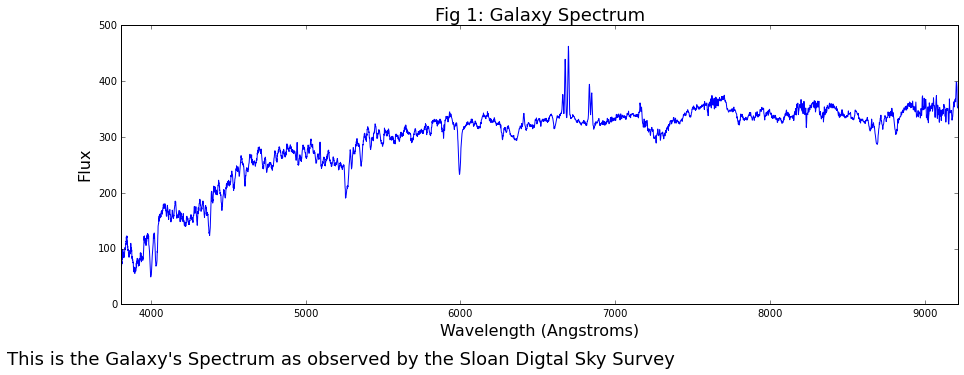


Pause



In [4]:
data = pyfits.getdata('spec-0429-51820-0056.fits.gz')
flux= np.array([i[0] for i in data]) #the flux of the data
wave= np.array([10**i[1] for i in data]) #the wavelegth of data
#
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "This is the Galaxy's Spectrum as observed by the Sloan Digtal Sky Survey", fontsize = 18)
plt.plot(wave,flux)
plt.xlim(min(wave),max(wave))
ai.figName('Fig 1: Galaxy Spectrum','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

C:\Users\Aidan\Anaconda\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


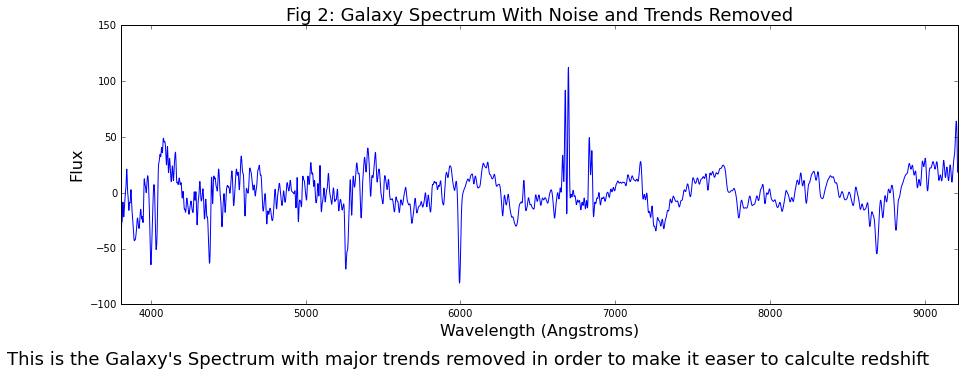


Pause



In [5]:
lt = ai.leastSquare(wave, flux, np.ones(len(wave)))
line = lt[1] * wave + lt[0] #the best fit line of the data
flux1 = flux - line #removes any linear trend from the data
#
fouier = np.fft.fft(flux1) #makes the data into a fouier series
freq = np.fft.fftfreq(fouier.size,2.1) #frequencies of the fouier series
#
fouier[np.abs(freq) < .00085] = 0
fouier[np.abs(freq) > .05] = 0 #removes high frequencies and low frequencies from the data
#
fluxN=np.fft.ifft(fouier) #converts the data out of a fouier series
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "This is the Galaxy's Spectrum with major trends removed in order to make it easer to calculte redshift", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
ai.figName('Fig 2: Galaxy Spectrum With Noise and Trends Removed','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

In [6]:
data1 = np.genfromtxt('linelist-0429-51820-0056.csv',delimiter=',',dtype=str, skip_header=1)
restWave = data1[:,1] #the rest wavelength
restWave = restWave.astype(np.float)
elements = data1[:,0]

In [7]:
red = redshiftFinder(restWave, wave, fluxN)

redshift 0.017


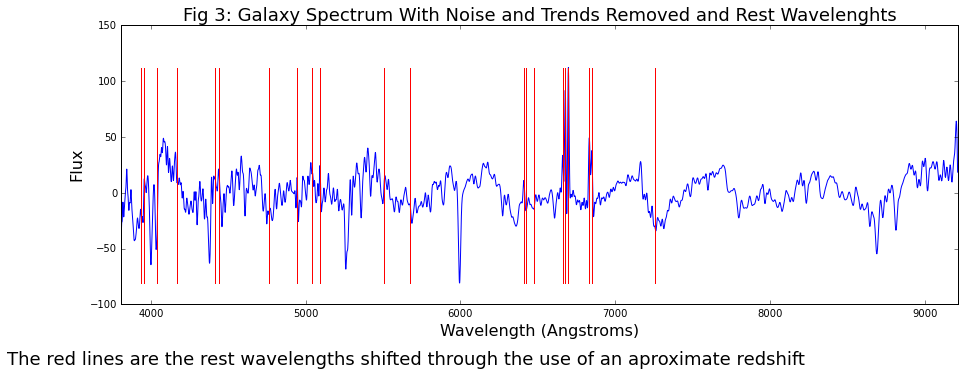


Pause



In [8]:
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "The red lines are the rest wavelengths shifted through the use of an aproximate redshift", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
waveajusted = (red + 1) * restWave
for i in waveajusted:
    plt.plot([i,i],[np.min(fluxN),np.max(fluxN)], color = 'red')
ai.figName('Fig 3: Galaxy Spectrum With Noise and Trends Removed and Rest Wavelenghts','Wavelength (Angstroms)','Flux')
print 'redshift', red
plt.show()
ai.pause()

0.0171243535181 +- 8.30441974594e-06
1.40521743176


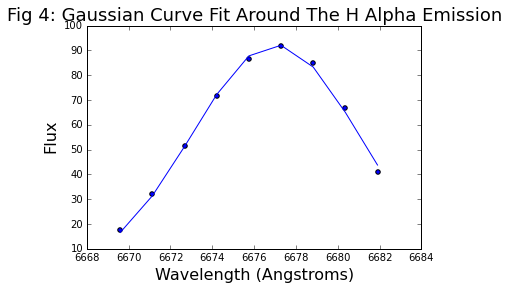

In [9]:
Red = np.array([])
Error = np.array([])
hA = restWave[elements == 'H alpha']
true_red, error,rms = ultra_redshiftFinder_v2(wave, fluxN, hA, 7., 7.,red)
print true_red[0], '+-', error[0]
print rms
Red = np.append(Red, true_red[0])
Error = np.append(Error, error[0])
ai.figName('Fig 4: Gaussian Curve Fit Around The H Alpha Emission','Wavelength (Angstroms)','Flux')
plt.show()

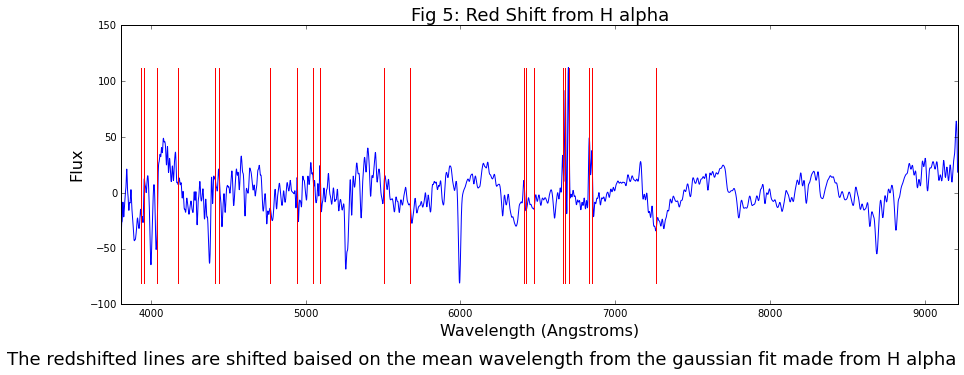


Pause



In [10]:
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "The redshifted lines are shifted baised on the mean wavelength from the gaussian fit made from H alpha", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
waveajusted = (true_red[0] + 1) * restWave
for i in waveajusted:
    plt.plot([i,i],[np.min(fluxN),np.max(fluxN)], color = 'red')
ai.figName('Fig 5: Red Shift from H alpha','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

0.016841883179 +- 1.385033587e-06
0.0528935035313


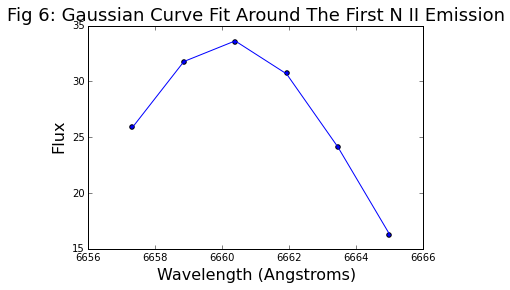

In [11]:
nII = restWave[elements == 'N II']
true_red1, error1 ,rms1 = ultra_redshiftFinder_v2(wave, fluxN, nII[0], 5, 5,red)
print true_red1, '+-', error1
print rms1
Red = np.append(Red, true_red1)
Error = np.append(Error, error1)
ai.figName('Fig 6: Gaussian Curve Fit Around The First N II Emission','Wavelength (Angstroms)','Flux')
plt.show()

First averaged redshift: 0.0168822601635 +- 1.18705358016e-06


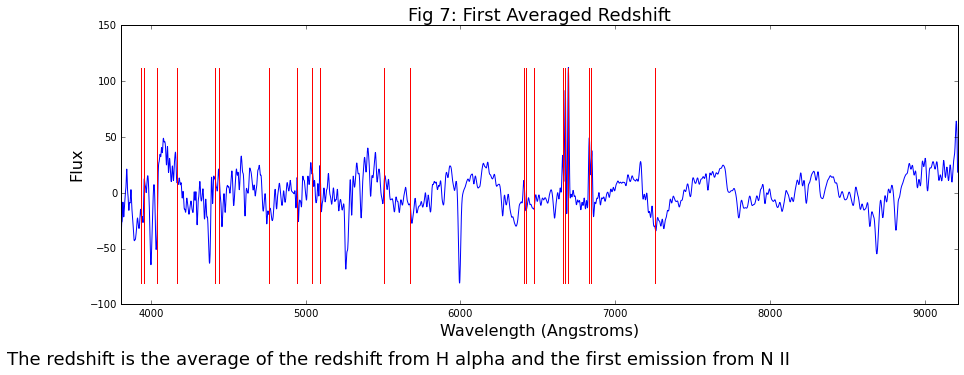


Pause



In [12]:
meanRed, meanError = Mean(Red, Error)
print 'First averaged redshift:', meanRed, '+-', meanError
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "The redshift is the average of the redshift from H alpha and the first emission from N II", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
waveajusted = (meanRed + 1) * restWave
for i in waveajusted:
    plt.plot([i,i],[np.min(fluxN),np.max(fluxN)], color = 'red')
ai.figName('Fig 7: First Averaged Redshift','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

0.0170153717322 +- 1.26652933666e-05
2.71421291858


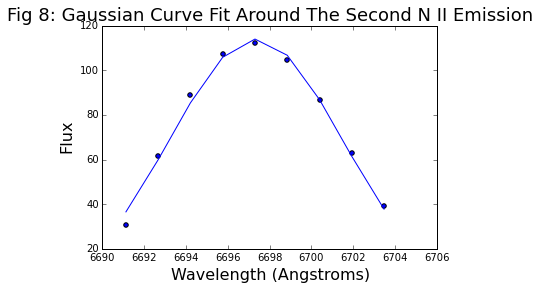

In [13]:
true_red2, error2 ,rms2 = ultra_redshiftFinder_v2(wave, fluxN, nII[1], 7, 7,red)
print true_red2, '+-', error2
print rms2
Red = np.append(Red, true_red2)
Error = np.append(Error, error2)
ai.figName('Fig 8: Gaussian Curve Fit Around The Second N II Emission','Wavelength (Angstroms)','Flux')
plt.show()

Second averaged redshift: 0.0168936669355 +- 1.08533101953e-06


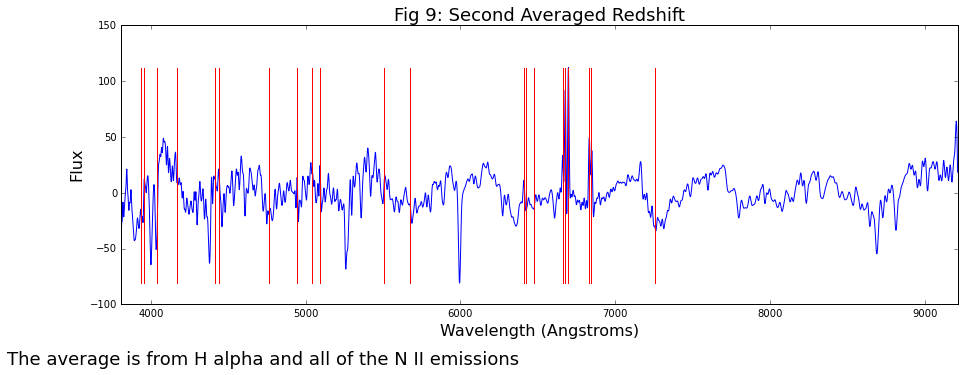


Pause



In [14]:
meanRed, meanError = Mean(Red, Error)
print 'Second averaged redshift:', meanRed, '+-', meanError
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "The average is from H alpha and all of the N II emissions", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
waveajusted = (meanRed + 1) * restWave
for i in waveajusted:
    plt.plot([i,i],[np.min(fluxN),np.max(fluxN)], color = 'red')
ai.figName('Fig 9: Second Averaged Redshift','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

0.0170236713708 +- 1.7681398587e-05
1.59121637404


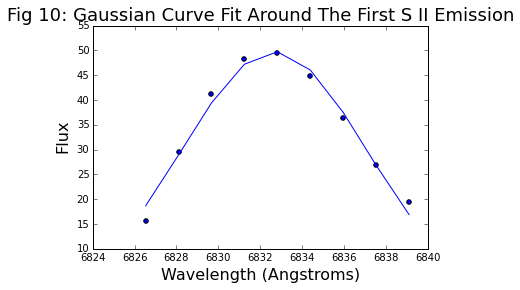

In [15]:
sII = restWave[elements == 'S II']
true_red3, error3 ,rms3 = ultra_redshiftFinder_v2(wave, fluxN, sII[0], 7, 7,red)
print true_red3, '+-', error3
print rms3
Red = np.append(Red, true_red3)
Error = np.append(Error, error3)
ai.figName('Fig 10: Gaussian Curve Fit Around The First S II Emission','Wavelength (Angstroms)','Flux')
plt.show()

Third averaged redshift: 0.0169011854456 +- 1.02256337452e-06


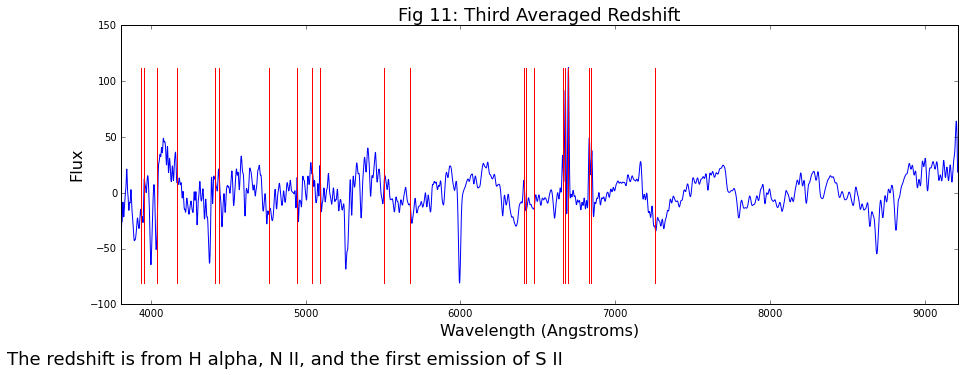


Pause



In [16]:
meanRed, meanError = Mean(Red, Error)
print 'Third averaged redshift:', meanRed, '+-', meanError
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "The redshift is from H alpha, N II, and the first emission of S II", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
waveajusted = (meanRed + 1) * restWave
for i in waveajusted:
    plt.plot([i,i],[np.min(fluxN),np.max(fluxN)], color = 'red')
ai.figName('Fig 11: Third Averaged Redshift','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

0.0170799654076 +- 3.9651266269e-05
2.49389570376


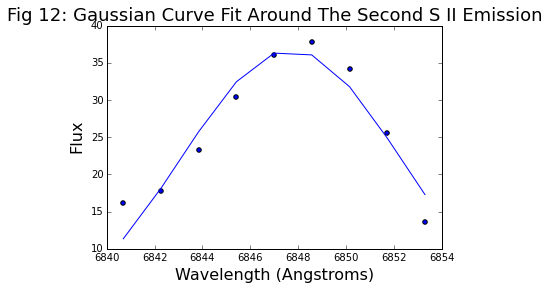

In [17]:
true_red4, error4 ,rms4 = ultra_redshiftFinder_v2(wave, fluxN, sII[1], 7, 7,red)
print true_red4, '+-', error4
print rms4
Red = np.append(Red, true_red4)
Error = np.append(Error, error4)
ai.figName('Fig 12: Gaussian Curve Fit Around The Second S II Emission','Wavelength (Angstroms)','Flux')
plt.show()

Fourth averaged redshift: 0.0169056800763 +- 9.96855545578e-07


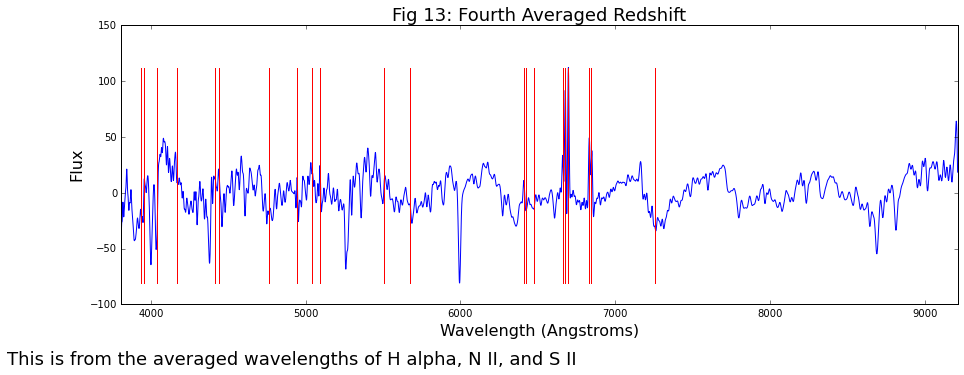


Pause



In [18]:
meanRed, meanError = Mean(Red, Error)
print 'Fourth averaged redshift:', meanRed, '+-', meanError
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "This is from the averaged wavelengths of H alpha, N II, and S II", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
waveajusted = (meanRed + 1) * restWave
for i in waveajusted:
    plt.plot([i,i],[np.min(fluxN),np.max(fluxN)], color = 'red')
ai.figName('Fig 13: Fourth Averaged Redshift','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

In [19]:
true_redN, errorN, rmsN = ultra_redshiftFinder_v2(wave, fluxN, restWave[4], 7, 7,red, False)
Red = np.append(Red, true_redN)
Error = np.append(Error, errorN)
#
true_redN, errorN ,rmsN = ultra_redshiftFinder_v2(wave, fluxN, restWave[6], 3, 3,red, False)
Red = np.append(Red, true_redN)
Error = np.append(Error, errorN)
#
true_redN, errorN ,rmsN = ultra_redshiftFinder_v2(wave, fluxN, restWave[7], 10, 10,red, False)
Red = np.append(Red, true_redN)
Error = np.append(Error, errorN)
#
true_redN, errorN ,rmsN = ultra_redshiftFinder_v2(wave, fluxN, restWave[9], 4, 4,red, False)
Red = np.append(Red, true_redN)
Error = np.append(Error, errorN)
#
true_redN, errorN ,rmsN = ultra_redshiftFinder_v2(wave, fluxN, restWave[11], 5, 5,red, False)
Red = np.append(Red, true_redN)
Error = np.append(Error, errorN)
#
true_redN, errorN ,rmsN = ultra_redshiftFinder_v2(wave, fluxN, restWave[14], 7, 7,red, False)
Red = np.append(Red, true_redN)
Error = np.append(Error, errorN)

Final averaged redshift: 0.0169026682262 +- 8.31322530679e-07


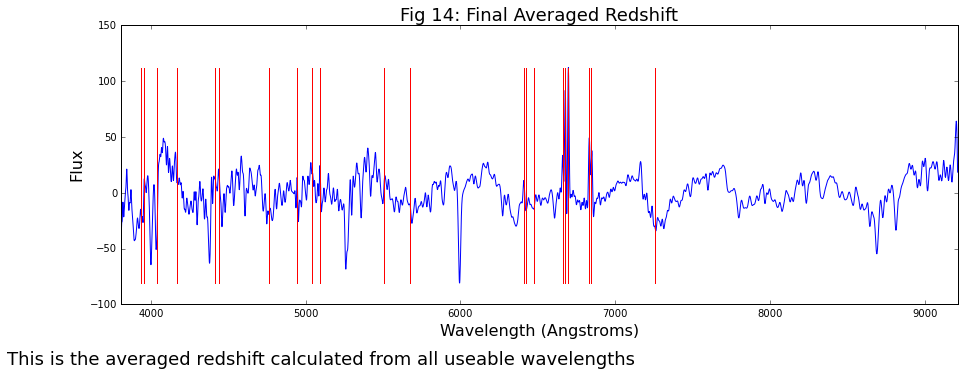


Pause



In [20]:
meanRed, meanError = Mean(Red, Error)
print 'Final averaged redshift:', meanRed, '+-', meanError
plt.figure(figsize=(15,5))
plt.figtext(.02, -.04, "This is the averaged redshift calculated from all useable wavelengths", fontsize = 18)
plt.plot(wave,fluxN)
plt.xlim(min(wave),max(wave))
waveajusted = (meanRed + 1) * restWave
for i in waveajusted:
    plt.plot([i,i],[np.min(fluxN),np.max(fluxN)], color = 'red')
ai.figName('Fig 14: Final Averaged Redshift','Wavelength (Angstroms)','Flux')
plt.show()
ai.pause()

''

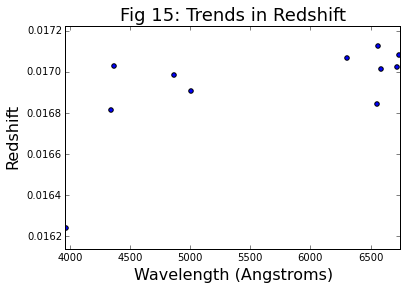

In [21]:
usedWaves = np.array([hA, nII[0], nII[1], sII[0], sII[1], restWave[4], restWave[6], restWave[7], restWave[9], restWave[11], restWave[14]])
plt.scatter(usedWaves,Red)
plt.ylim(min(Red)-.0001,max(Red)+.0001)
plt.xlim(min(usedWaves)-10,max(usedWaves)+10)
ai.figName('Fig 15: Trends in Redshift','Wavelength (Angstroms)','Redshift')

In [23]:
for n in range(len(Error)-1):
    x = chiRedshift(usedWaves[n], usedWaves[n+1], Error[n], Error[n+1])
    cdf = 1 - sc.chi2.cdf(x,1)
    print x
    print cdf

[  3.04860047e+12]
[ 0.]
7.71992632175e+12
0.0
3.73941811645e+13
0.0
110013780903.0
0.0
1.46305976901e+15
0.0
3.40198807702e+13
0.0
639400296188.0
0.0
1.22046350357e+14
0.0
8.45001978562e+12
0.0
6.75583344946e+14
0.0
